In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import uuid
import os
import os.path
import utils
import utils.wavelet
import utils.data
import utils.data.augmentation
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
import wfdb
import json
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from utils.signal import StandardHeader

# Data loader to un-clutter code    
def load_data(filepath):
    dic = dict()
    with open(filepath) as f:
        text = list(f)
    for line in text:
        line = line.replace(' ','').replace('\n','').replace(',,','')
        if line[-1] == ',': line = line[:-1]
        head = line.split(',')[0]
        tail = line.split(',')[1:]
        if tail == ['']:
            tail = np.asarray([])
        else:
            tail = np.asarray(tail).astype(int)

        dic[head] = tail
    return dic


def trailonset(sig,on):
    on = on-sig[0]
    off = on-sig[0]+sig[-1]
    sig = sig+np.linspace(on,off,sig.size)
    
    return sig

# Load LUDB

In [3]:
dataset = {}
Pon = {}
Ppeak = {}
Poff = {}
QRSon = {}
QRSpeak = {}
QRSoff = {}
Ton = {}
Tpeak = {}
Toff = {}
group = {}

for i in tqdm.tqdm(range(200)):
    (signal, header) = wfdb.rdsamp(r'C:\Users\Emilio\Documents\DADES\DADES\Delineator\ludb\{}'.format(i+1))
    sortOrder = np.where(np.array([x.upper() for x in header['sig_name']])[:,None] == StandardHeader)[1]
    signal = signal[:,sortOrder]
    if header['fs'] != 500:
        print(header['fs'])
    signal = sp.signal.decimate(signal,2,axis=0)
    
    # 1st step: reduce noise
    signal = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250., 'high'),signal.T).T
    signal = sp.signal.filtfilt(*sp.signal.butter(4, 125.0/250.,  'low'),signal.T).T

    # 2nd step: retrieve onsets and offsets
    for j in range(len(StandardHeader)):
        lead = StandardHeader[j]
        name = str(i+1)+"_"+lead
        ann = wfdb.rdann(r'C:\Users\Emilio\Documents\DADES\DADES\Delineator\ludb\{}'.format(i+1),'atr_{}'.format(lead.lower()))
        dataset[name] = signal[:,j]
        
        locP = np.where(np.array(ann.symbol) == 'p')[0]
        if len(locP) != 0:
            if locP[0]-1 < 0:
                locP = locP[1:]
            if locP[-1]+1 == len(ann.sample):
                locP = locP[:-1]
        Pon[name] = ann.sample[locP-1]//2
        Ppeak[name] = ann.sample[locP]//2
        Poff[name] = ann.sample[locP+1]//2

        locQRS = np.where(np.array(ann.symbol) == 'N')[0]
        if len(locQRS) != 0:
            if locQRS[0]-1 < 0:
                locQRS = locQRS[1:]
            if locQRS[-1]+1 == len(ann.sample):
                locQRS = locQRS[:-1]
        QRSon[name] = ann.sample[locQRS-1]//2
        QRSpeak[name] = ann.sample[locQRS]//2
        QRSoff[name] = ann.sample[locQRS+1]//2

        locT = np.where(np.array(ann.symbol) == 't')[0]
        if len(locT) != 0:
            if locT[0]-1 < 0:
                locT = locT[1:]
            if locT[-1]+1 == len(ann.sample):
                locT = locT[:-1]
        Ton[name] = ann.sample[locT-1]//2
        Tpeak[name] = ann.sample[locT]//2
        Toff[name] = ann.sample[locT+1]//2
        
        # Store group
        group[name] = str(i+1)

dataset = pd.DataFrame(dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:29<00:00,  6.71it/s]


In [4]:
Psignal = {}
PQsignal = {}
QRSsignal = {}
STsignal = {}
Tsignal = {}
TPsignal = {}

Pgroup = {}
PQgroup = {}
QRSgroup = {}
STgroup = {}
Tgroup = {}
TPgroup = {}

for k in tqdm.tqdm(dataset.keys()):
    # Buggy files
    if k in ['116_{}'.format(h) for h in StandardHeader]:
        continue
    pon = Pon.get(k,np.array([]))
    pof = Poff.get(k,np.array([]))
    qon = QRSon.get(k,np.array([]))
    qof = QRSoff.get(k,np.array([]))
    ton = Ton.get(k,np.array([]))
    tof = Toff.get(k,np.array([]))
    
    unordered_samples = np.concatenate([pon,pof,qon,qof,ton,tof,]).astype(float)
    unordered_symbols = np.concatenate([['Pon']*pon.size,['Poff']*pof.size,
                                        ['QRSon']*qon.size,['QRSoff']*qof.size,
                                        ['Ton']*ton.size,['Toff']*tof.size,])
    # Sort fiducials taking logical orders if same sample of occurrence
    # There is (I'm definitely sure) a better way to do it
    samples = []
    symbols = []
    for i in range(unordered_samples.size):
        minimum = np.where(unordered_samples == min(unordered_samples))[0]
        if minimum.size == 1:
            minimum = minimum[0]
            samples.append(int(unordered_samples[minimum]))
            symbols.append(unordered_symbols[minimum])
            unordered_samples[minimum] = np.inf
        elif minimum.size == 2:
            if symbols[-1] == 'Pon':
                if unordered_symbols[minimum[0]] == 'Poff':
                    samples.append(int(unordered_samples[minimum[0]]))
                    symbols.append(unordered_symbols[minimum[0]])
                    unordered_samples[minimum[0]] = np.inf
                elif unordered_symbols[minimum[1]] == 'Poff':
                    samples.append(int(unordered_samples[minimum[1]]))
                    symbols.append(unordered_symbols[minimum[1]])
                    unordered_samples[minimum[1]] = np.inf
            elif symbols[-1] == 'QRSon':
                if unordered_symbols[minimum[0]] == 'QRSoff':
                    samples.append(int(unordered_samples[minimum[0]]))
                    symbols.append(unordered_symbols[minimum[0]])
                    unordered_samples[minimum[0]] = np.inf
                elif unordered_symbols[minimum[1]] == 'QRSoff':
                    samples.append(int(unordered_samples[minimum[1]]))
                    symbols.append(unordered_symbols[minimum[1]])
                    unordered_samples[minimum[1]] = np.inf
            elif symbols[-1] == 'Ton':
                if unordered_symbols[minimum[0]] == 'Toff':
                    samples.append(int(unordered_samples[minimum[0]]))
                    symbols.append(unordered_symbols[minimum[0]])
                    unordered_samples[minimum[0]] = np.inf
                elif unordered_symbols[minimum[1]] == 'Toff':
                    samples.append(int(unordered_samples[minimum[1]]))
                    symbols.append(unordered_symbols[minimum[1]])
                    unordered_samples[minimum[1]] = np.inf
            else:
                raise ValueError("Should not happen at all")
        else:
            raise ValueError("Definitely should not happen. Check file {}".format(k))
    samples = np.array(samples)
    symbols = np.array(symbols)
    
    # Extract segments
    for i in range(samples.size-1):
        if samples[i] == samples[i+1]:
            continue
        if symbols[i] == 'Pon':
            if symbols[i+1] == 'Poff':
                Psignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                Pgroup[k + '_' + str(i)] = (k,group[k])
            else:
                print("Check file {}. P onset not followed by offset".format(k))
        elif symbols[i] == 'QRSon':
            if symbols[i+1] == 'QRSoff':
                QRSsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                QRSgroup[k + '_' + str(i)] = (k,group[k])
            else:
                print("Check file {}. QRS onset not followed by offset".format(k))
        elif symbols[i] == 'Ton':
            if symbols[i+1] == 'Toff':
                Tsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                Tgroup[k + '_' + str(i)] = (k,group[k])
            else:
                print("Check file {}. T onset not followed by offset".format(k))
        elif symbols[i] == 'Poff':
            if symbols[i+1] == 'Pon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'QRSon':
                PQsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                PQgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'Ton':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] in ['Poff','QRSoff','Toff']:
                print("Check file {}. P offset not followed by onset".format(k))
        elif symbols[i] == 'QRSoff':
            if symbols[i+1] == 'Pon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'QRSon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'Ton':
                STsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                STgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] in ['Poff','QRSoff','Toff']:
                print("Check file {}. P offset not followed by onset".format(k))
        elif symbols[i] == 'Toff':
            if symbols[i+1] == 'Pon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'QRSon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'Ton':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] in ['Poff','QRSoff','Toff']:
                print("Check file {}. P offset not followed by onset".format(k))
        else:
            raise ValueError("This should definitely not happen")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:25<00:00, 95.87it/s]


In [5]:
print(len(Pgroup))
print(len(PQgroup))
print(len(QRSgroup))
print(len(STgroup))
print(len(Tgroup))
print(len(TPgroup))

16641
16625
21789
19477
19497
19334


# Load QT db

In [6]:
path = r'C:\Users\Emilio\Documents\DADES\DADES\PhysioNet\QTDB\2020'

#### LOAD DATASETS ####
dataset             = pd.read_csv(os.path.join(path, 'Dataset.csv'), index_col=0)
dataset             = dataset.sort_index(axis=1)
labels              = np.asarray(list(dataset)) # In case no data augmentation is applied
description         = dataset.describe()
group               = {k: '_'.join(k.split('_')[:-1]) for k in dataset}

# Zero-center data
for key in description:
    dataset[key]    = (dataset[key] - description[key]['mean'])/description[key]['std']
    
Pon = load_data(os.path.join(path, 'PonNew.csv'))
Poff = load_data(os.path.join(path, 'PoffNew.csv'))
QRSon = load_data(os.path.join(path, 'QRSonNew.csv'))
QRSoff = load_data(os.path.join(path, 'QRSoffNew.csv'))
Ton = load_data(os.path.join(path, 'TonNew.csv'))
Toff = load_data(os.path.join(path, 'ToffNew.csv'))

In [7]:
for k in tqdm.tqdm(dataset.keys()):
    # Buggy files
    if k in ['sel232_0', 'sel232_1']:
        continue
    pon = Pon.get(k,np.array([]))
    pof = Poff.get(k,np.array([]))
    qon = QRSon.get(k,np.array([]))
    qof = QRSoff.get(k,np.array([]))
    ton = Ton.get(k,np.array([]))
    tof = Toff.get(k,np.array([]))
    
    unordered_samples = np.concatenate([pon,pof,qon,qof,ton,tof,]).astype(float)
    unordered_symbols = np.concatenate([['Pon']*pon.size,['Poff']*pof.size,
                                        ['QRSon']*qon.size,['QRSoff']*qof.size,
                                        ['Ton']*ton.size,['Toff']*tof.size,])
    # Sort fiducials taking logical orders if same sample of occurrence
    # There is (I'm definitely sure) a better way to do it
    samples = []
    symbols = []
    for i in range(unordered_samples.size):
        minimum = np.where(unordered_samples == min(unordered_samples))[0]
        if minimum.size == 1:
            minimum = minimum[0]
            samples.append(int(unordered_samples[minimum]))
            symbols.append(unordered_symbols[minimum])
            unordered_samples[minimum] = np.inf
        elif minimum.size == 2:
            if symbols[-1] == 'Pon':
                if unordered_symbols[minimum[0]] == 'Poff':
                    samples.append(int(unordered_samples[minimum[0]]))
                    symbols.append(unordered_symbols[minimum[0]])
                    unordered_samples[minimum[0]] = np.inf
                elif unordered_symbols[minimum[1]] == 'Poff':
                    samples.append(int(unordered_samples[minimum[1]]))
                    symbols.append(unordered_symbols[minimum[1]])
                    unordered_samples[minimum[1]] = np.inf
            elif symbols[-1] == 'QRSon':
                if unordered_symbols[minimum[0]] == 'QRSoff':
                    samples.append(int(unordered_samples[minimum[0]]))
                    symbols.append(unordered_symbols[minimum[0]])
                    unordered_samples[minimum[0]] = np.inf
                elif unordered_symbols[minimum[1]] == 'QRSoff':
                    samples.append(int(unordered_samples[minimum[1]]))
                    symbols.append(unordered_symbols[minimum[1]])
                    unordered_samples[minimum[1]] = np.inf
            elif symbols[-1] == 'Ton':
                if unordered_symbols[minimum[0]] == 'Toff':
                    samples.append(int(unordered_samples[minimum[0]]))
                    symbols.append(unordered_symbols[minimum[0]])
                    unordered_samples[minimum[0]] = np.inf
                elif unordered_symbols[minimum[1]] == 'Toff':
                    samples.append(int(unordered_samples[minimum[1]]))
                    symbols.append(unordered_symbols[minimum[1]])
                    unordered_samples[minimum[1]] = np.inf
            else:
                raise ValueError("Should not happen at all")
        else:
            raise ValueError("Definitely should not happen. Check file {}".format(k))
    samples = np.array(samples)
    symbols = np.array(symbols)
    
    # Extract segments
    for i in range(samples.size-1):
        if samples[i] == samples[i+1]:
            continue
        if symbols[i] == 'Pon':
            if symbols[i+1] == 'Poff':
                Psignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                Pgroup[k + '_' + str(i)] = (k,group[k])
            else:
                print("Check file {}. P onset {} not followed by offset {}".format(k, samples[i], samples[i+1]))
        elif symbols[i] == 'QRSon':
            if symbols[i+1] == 'QRSoff':
                QRSsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                QRSgroup[k + '_' + str(i)] = (k,group[k])
            else:
                print("Check file {}. QRS onset {} not followed by offset {}".format(k, samples[i], samples[i+1]))
        elif symbols[i] == 'Ton':
            if symbols[i+1] == 'Toff':
                Tsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                Tgroup[k + '_' + str(i)] = (k,group[k])
            else:
                print("Check file {}. T onset {} not followed by offset {}".format(k, samples[i], samples[i+1]))
        elif symbols[i] == 'Poff':
            if symbols[i+1] == 'Pon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'QRSon':
                PQsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                PQgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'Ton':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] in ['Poff','QRSoff','Toff']:
                print("Check file {}. P offset {} not followed by onset {}".format(k, samples[i], samples[i+1]))
        elif symbols[i] == 'QRSoff':
            if symbols[i+1] == 'Pon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'QRSon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'Ton':
                STsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                STgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] in ['Poff','QRSoff','Toff']:
                print("Check file {}. P offset {} not followed by onset {}".format(k, samples[i], samples[i+1]))
        elif symbols[i] == 'Toff':
            if symbols[i+1] == 'Pon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'QRSon':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] == 'Ton':
                TPsignal[k + '_' + str(i)] = dataset[k][samples[i]:samples[i+1]].values
                TPgroup[k + '_' + str(i)] = (k,group[k])
            elif symbols[i+1] in ['Poff','QRSoff','Toff']:
                print("Check file {}. P offset {} not followed by onset {}".format(k, samples[i], samples[i+1]))
        else:
            raise ValueError("This should definitely not happen")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:13<00:00, 15.29it/s]


In [8]:
print(len(Pgroup))
print(len(PQgroup))
print(len(QRSgroup))
print(len(STgroup))
print(len(Tgroup))
print(len(TPgroup))

22851
22797
28869
26173
26405
26236


# Normalize amplitudes

In [9]:
metric = np.median
normalization_strategy = 0

amplitudes = {stratification[normalization_strategy]: [] for stratification in list(set(QRSgroup.values()))}
for k in QRSsignal:
    stratification = QRSgroup[k]
    g = stratification[normalization_strategy]
    amplitudes[g].append(np.max(np.abs(utils.signal.on_off_correction(QRSsignal[k]))))
    
for k in Psignal:
    stratification = Pgroup[k]
    g = stratification[normalization_strategy]
    Psignal[k] /= metric(amplitudes[g])

for k in PQsignal:
    stratification = PQgroup[k]
    g = stratification[normalization_strategy]
    PQsignal[k] /= metric(amplitudes[g])

for k in QRSsignal:
    stratification = QRSgroup[k]
    g = stratification[normalization_strategy]
    QRSsignal[k] /= metric(amplitudes[g])

for k in STsignal:
    stratification = STgroup[k]
    g = stratification[normalization_strategy]
    STsignal[k] /= metric(amplitudes[g])

for k in Tsignal:
    stratification = Tgroup[k]
    g = stratification[normalization_strategy]
    Tsignal[k] /= metric(amplitudes[g])

for k in TPsignal:
    stratification = TPgroup[k]
    g = stratification[normalization_strategy]
    TPsignal[k] /= metric(amplitudes[g])

# Delete too short or too long signals

In [10]:
# Signal lengths
Plength = {k: len(Psignal[k]) for k in Psignal.keys()}
PQlength = {k: len(PQsignal[k]) for k in PQsignal.keys()}
QRSlength = {k: len(QRSsignal[k]) for k in QRSsignal.keys()}
STlength = {k: len(STsignal[k]) for k in STsignal.keys()}
Tlength = {k: len(Tsignal[k]) for k in Tsignal.keys()}
TPlength = {k: len(TPsignal[k]) for k in TPsignal.keys()}

# # TP waves - inverse
# TPinv = {}
# for k in TPsignal.keys():
#     if k not in TPinv:
#         TPinv[len(TPsignal[k])] = []
#     TPinv[len(TPsignal[k])].append(k)
# 192,217,242,249,252,266,271,273,276,277,283,286,287,288,290,298,306,317,325
# plt.hist(Plength.values(),bins=100)

In [11]:
# Filter signals by length
for k in list(Psignal.keys()):
    if not ((len(Psignal[k]) > 1) and (len(Psignal[k]) < 45)):
        Psignal.pop(k)
        Pgroup.pop(k)
for k in list(PQsignal.keys()):
    if not ((len(PQsignal[k]) > 1) and (len(PQsignal[k]) < 35)):
        PQsignal.pop(k)
        PQgroup.pop(k)
for k in list(QRSsignal.keys()):
    if not ((len(QRSsignal[k]) > 1) and (len(QRSsignal[k]) < 50)):
        QRSsignal.pop(k)
        QRSgroup.pop(k)
for k in list(STsignal.keys()):
    if not ((len(STsignal[k]) > 1) and (len(STsignal[k]) < 65)):
        STsignal.pop(k)
        STgroup.pop(k)
for k in list(Tsignal.keys()):
    if not ((len(Tsignal[k]) > 1) and (len(Tsignal[k]) < 100)):
        Tsignal.pop(k)
        Tgroup.pop(k)
for k in list(TPsignal.keys()):
    if not ((len(TPsignal[k]) > 1) and (len(TPsignal[k]) < 325)):
        TPsignal.pop(k)
        TPgroup.pop(k)

In [12]:
print(len(Pgroup))
print(len(PQgroup))
print(len(QRSgroup))
print(len(STgroup))
print(len(Tgroup))
print(len(TPgroup))

22734
22521
28558
25732
26221
26038


# Adding inverses - Data augmentation

In [13]:
Psignal.update({'-'+k: -Psignal[k] for k in Psignal})
Pgroup.update({'-'+k: Pgroup[k] for k in Pgroup})
PQsignal.update({'-'+k: -PQsignal[k] for k in PQsignal})
PQgroup.update({'-'+k: PQgroup[k] for k in PQgroup})
QRSsignal.update({'-'+k: -QRSsignal[k] for k in QRSsignal})
QRSgroup.update({'-'+k: QRSgroup[k] for k in QRSgroup})
STsignal.update({'-'+k: -STsignal[k] for k in STsignal})
STgroup.update({'-'+k: STgroup[k] for k in STgroup})
Tsignal.update({'-'+k: -Tsignal[k] for k in Tsignal})
Tgroup.update({'-'+k: Tgroup[k] for k in Tgroup})
TPsignal.update({'-'+k: -TPsignal[k] for k in TPsignal})
TPgroup.update({'-'+k: TPgroup[k] for k in TPgroup})

In [14]:
print(len(Pgroup))
print(len(PQgroup))
print(len(QRSgroup))
print(len(STgroup))
print(len(Tgroup))
print(len(TPgroup))

45468
45042
57116
51464
52442
52076


# Mixup - Data augmentation

In [15]:
# number = 1

# too_much_it_squares_amount_of_data

# permuted = np.random.permutation(list(Psignal))
# for k1 in tqdm.tqdm(list(Psignal.keys())):
#     visited = {}
#     (k_all_1,g_1) = Pgroup[k1]
#     counter = 0
#     for k2 in permuted:
#         (k_all_2,g_2) = Pgroup[k2]
#         if (k1 != k2) & (g_1 != g_2):
#             visited[g_2] = visited.get(g_2,0)+1
#             if visited[g_2] > number:
#                 continue
#             if Psignal[k1].size != Psignal[k2].size:
#                 intlen = np.random.randint(min([Psignal[k1].size,Psignal[k2].size]),max([Psignal[k1].size,Psignal[k2].size]))
#                 x1 = sp.interpolate.interp1d(np.linspace(0,1,Psignal[k1].size),Psignal[k1])(np.linspace(0,1,intlen))
#                 x2 = sp.interpolate.interp1d(np.linspace(0,1,Psignal[k2].size),Psignal[k2])(np.linspace(0,1,intlen))
#             else:
#                 x1 = Psignal[k1]
#                 x2 = Psignal[k2]
#             (xhat,lmbda) = utils.data.augmentation.mixup(x1,x2,5.,1.5)
#             Psignal[k1+'m'+str(counter)] = xhat.squeeze()
#             Pgroup[k1+'m'+str(counter)] = Pgroup[k1]
#             counter += 1

# permuted = np.random.permutation(list(QRSsignal))
# for k1 in tqdm.tqdm(list(QRSsignal.keys())):
#     visited = {}
#     (k_all_1,g_1) = QRSgroup[k1]
#     counter = 0
#     for k2 in permuted:
#         (k_all_2,g_2) = QRSgroup[k2]
#         if (k1 != k2) & (g_1 != g_2):
#             visited[g_2] = visited.get(g_2,0)+1
#             if visited[g_2] > number:
#                 continue
#             if QRSsignal[k1].size != QRSsignal[k2].size:
#                 intlen = np.random.randint(min([QRSsignal[k1].size,QRSsignal[k2].size]),max([QRSsignal[k1].size,QRSsignal[k2].size]))
#                 x1 = sp.interpolate.interp1d(np.linspace(0,1,QRSsignal[k1].size),QRSsignal[k1])(np.linspace(0,1,intlen))
#                 x2 = sp.interpolate.interp1d(np.linspace(0,1,QRSsignal[k2].size),QRSsignal[k2])(np.linspace(0,1,intlen))
#             else:
#                 x1 = QRSsignal[k1]
#                 x2 = QRSsignal[k2]
#             (xhat,lmbda) = utils.data.augmentation.mixup(x1,x2,5.,1.5)
#             QRSsignal[k1+'m'+str(counter)] = xhat.squeeze()
#             QRSgroup[k1+'m'+str(counter)] = QRSgroup[k1]
#             counter += 1

# permuted = np.random.permutation(list(Tsignal))
# for k1 in tqdm.tqdm(list(Tsignal.keys())):
#     visited = {}
#     (k_all_1,g_1) = Tgroup[k1]
#     counter = 0
#     for k2 in permuted:
#         (k_all_2,g_2) = Tgroup[k2]
#         if (k1 != k2) & (g_1 != g_2):
#             visited[g_2] = visited.get(g_2,0)+1
#             if visited[g_2] > number:
#                 continue
#             if Tsignal[k1].size != Tsignal[k2].size:
#                 intlen = np.random.randint(min([Tsignal[k1].size,Tsignal[k2].size]),max([Tsignal[k1].size,Tsignal[k2].size]))
#                 x1 = sp.interpolate.interp1d(np.linspace(0,1,Tsignal[k1].size),Tsignal[k1])(np.linspace(0,1,intlen))
#                 x2 = sp.interpolate.interp1d(np.linspace(0,1,Tsignal[k2].size),Tsignal[k2])(np.linspace(0,1,intlen))
#             else:
#                 x1 = Tsignal[k1]
#                 x2 = Tsignal[k2]
#             (xhat,lmbda) = utils.data.augmentation.mixup(x1,x2,5.,1.5)
#             Tsignal[k1+'m'+str(counter)] = xhat.squeeze()
#             Tgroup[k1+'m'+str(counter)] = Tgroup[k1]
#             counter += 1

In [16]:
# print(len(Pgroup))
# print(len(PQgroup))
# print(len(QRSgroup))
# print(len(STgroup))
# print(len(Tgroup))
# print(len(TPgroup))

# Compute criteria

In [30]:
# Generate wavelets
Pwavelet = {k: utils.wavelet.transform(Psignal[k],250.).squeeze() for k in tqdm.tqdm(Psignal.keys())}
PQwavelet = {k: utils.wavelet.transform(PQsignal[k],250.).squeeze() for k in tqdm.tqdm(PQsignal.keys())}
QRSwavelet = {k: utils.wavelet.transform(QRSsignal[k],250.).squeeze() for k in tqdm.tqdm(QRSsignal.keys())}
STwavelet = {k: utils.wavelet.transform(STsignal[k],250.).squeeze() for k in tqdm.tqdm(STsignal.keys())}
Twavelet = {k: utils.wavelet.transform(Tsignal[k],250.).squeeze() for k in tqdm.tqdm(Tsignal.keys())}
TPwavelet = {k: utils.wavelet.transform(TPsignal[k],250.).squeeze() for k in tqdm.tqdm(TPsignal.keys())}

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52076/52076 [00:58<00:00, 893.86it/s]


In [221]:
# Generate criteria
s = 3 # wavelet scale
eps = np.finfo('float').eps
Pcriteria = {k: ((np.sign(Pwavelet[k][0,s]),(Pwavelet[k][0,s]-Pwavelet[k][1,s]+eps)/(np.max(Pwavelet[k][:,s])-np.min(Pwavelet[k][:,s]+eps))),
                 (np.sign(Pwavelet[k][-1,s]),(Pwavelet[k][-1,s]-Pwavelet[k][-2,s]+eps)/(np.max(Pwavelet[k][:,s])-np.min(Pwavelet[k][:,s]+eps)))) for k in Psignal.keys()}
PQcriteria = {k: ((np.sign(PQwavelet[k][0,s]),(PQwavelet[k][0,s]-PQwavelet[k][1,s]+eps)/(np.max(PQwavelet[k][:,s])-np.min(PQwavelet[k][:,s]+eps))),
                 (np.sign(PQwavelet[k][-1,s]),(PQwavelet[k][-1,s]-PQwavelet[k][-2,s]+eps)/(np.max(PQwavelet[k][:,s])-np.min(PQwavelet[k][:,s]+eps)))) for k in PQsignal.keys()}
QRScriteria = {k: ((np.sign(QRSwavelet[k][0,s]),(QRSwavelet[k][0,s]-QRSwavelet[k][1,s]+eps)/(np.max(QRSwavelet[k][:,s])-np.min(QRSwavelet[k][:,s]+eps))),
                 (np.sign(QRSwavelet[k][-1,s]),(QRSwavelet[k][-1,s]-QRSwavelet[k][-2,s]+eps)/(np.max(QRSwavelet[k][:,s])-np.min(QRSwavelet[k][:,s]+eps)))) for k in QRSsignal.keys()}
STcriteria = {k: ((np.sign(STwavelet[k][0,s]),(STwavelet[k][0,s]-STwavelet[k][1,s]+eps)/(np.max(STwavelet[k][:,s])-np.min(STwavelet[k][:,s]+eps))),
                 (np.sign(STwavelet[k][-1,s]),(STwavelet[k][-1,s]-STwavelet[k][-2,s]+eps)/(np.max(STwavelet[k][:,s])-np.min(STwavelet[k][:,s]+eps)))) for k in STsignal.keys()}
Tcriteria = {k: ((np.sign(Twavelet[k][0,s]),(Twavelet[k][0,s]-Twavelet[k][1,s]+eps)/(np.max(Twavelet[k][:,s])-np.min(Twavelet[k][:,s]+eps))),
                 (np.sign(Twavelet[k][-1,s]),(Twavelet[k][-1,s]-Twavelet[k][-2,s]+eps)/(np.max(Twavelet[k][:,s])-np.min(Twavelet[k][:,s]+eps)))) for k in Tsignal.keys()}
TPcriteria = {k: ((np.sign(TPwavelet[k][0,s]),(TPwavelet[k][0,s]-TPwavelet[k][1,s]+eps)/(np.max(TPwavelet[k][:,s])-np.min(TPwavelet[k][:,s]+eps))),
                 (np.sign(TPwavelet[k][-1,s]),(TPwavelet[k][-1,s]-TPwavelet[k][-2,s]+eps)/(np.max(TPwavelet[k][:,s])-np.min(TPwavelet[k][:,s]+eps)))) for k in TPsignal.keys()}

# Generate sample record with QT and LUDB

In [ ]:
Pkeys = list(Psignal.keys())
PQkeys = list(PQsignal.keys())
QRSkeys = list(QRSsignal.keys())
STkeys = list(STsignal.keys())
Tkeys = list(Tsignal.keys())
TPkeys = list(TPsignal.keys())

In [950]:
# %%timeit
N = 2048

# Hyperparams
size = 20
onset = np.random.randint(0,50)
begining_wave = np.random.randint(0,6)
has_P = np.random.rand(1) > 0.1
has_PQ = np.random.rand(1) > 0.2
has_ST = np.random.rand(1) > 0.2
has_BBB = np.random.rand(1) > 0.9
proba_P = 0.15
proba_PQ = 0.15
proba_QRS = 0.01
proba_ST = 0.15

##### Data structure
ids = []

##### Identifiers
id_P = np.random.randint(0,len(Psignal),size=size)
id_PQ = np.random.randint(0,len(PQsignal),size=size)
id_QRS = np.random.randint(0,len(QRSsignal),size=size)
id_ST = np.random.randint(0,len(STsignal),size=size)
id_T = np.random.randint(0,len(Tsignal),size=size)
id_TP = np.random.randint(0,len(TPsignal),size=size)

# In case QRS is not expressed
filt_QRS = np.random.rand(size) < proba_QRS

# P wave
id_P[(np.random.rand(size) < proba_P) | np.logical_not(has_P)] = -1
id_PQ[filt_QRS | (np.random.rand(size) < proba_PQ) | np.logical_not(has_PQ)] = -1
id_QRS[filt_QRS] = -1
id_ST[filt_QRS | (np.random.rand(size) < proba_ST) | np.logical_not(has_ST)] = -1
id_T[filt_QRS] = -1

beats = []
masks = []
offset = 0
record_size = 0
mark_break = False
for i in range(size):
    for j in range(6):
        if (i == 0) and (j < begining_wave): 
            continue
        if (j == 0) and (id_P[i] != -1):
            beats.append(trailonset(Psignal[Pkeys[id_P[i]]],offset))
            masks.append(np.full((beats[-1].size,),1,dtype='int8'))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 1) and (id_PQ[i] != -1):
            beats.append(trailonset(PQsignal[PQkeys[id_PQ[i]]],offset))
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 2) and (id_QRS[i] != -1):
            beats.append(trailonset(QRSsignal[QRSkeys[id_QRS[i]]],offset))
            masks.append(np.full((beats[-1].size,),2,dtype='int8'))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 3) and (id_ST[i] != -1):
            beats.append(trailonset(STsignal[STkeys[id_ST[i]]],offset))
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 4) and (id_T[i] != -1):
            beats.append(trailonset(Tsignal[Tkeys[id_T[i]]],offset))
            masks.append(np.full((beats[-1].size,),3,dtype='int8'))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (j == 5) and (id_TP[i] != -1):
            beats.append(trailonset(TPsignal[TPkeys[id_TP[i]]],offset))
            masks.append(np.zeros((beats[-1].size,),dtype='int8'))
            offset = beats[-1][-1]
            record_size += beats[-1].size
        if (record_size-onset) >= N:
            mark_break = True
            break
    if mark_break:
        break
        
# Obtain final stuff
signal = np.concatenate(beats)
masks = np.concatenate(masks)
masks_all = np.zeros((record_size,3),dtype=bool)
masks_all[:,0] = (masks == 1)
masks_all[:,1] = (masks == 2)
masks_all[:,2] = (masks == 3)

# Move onset
signal = signal[onset:onset+N]
masks_all = masks_all[onset:onset+N,:]

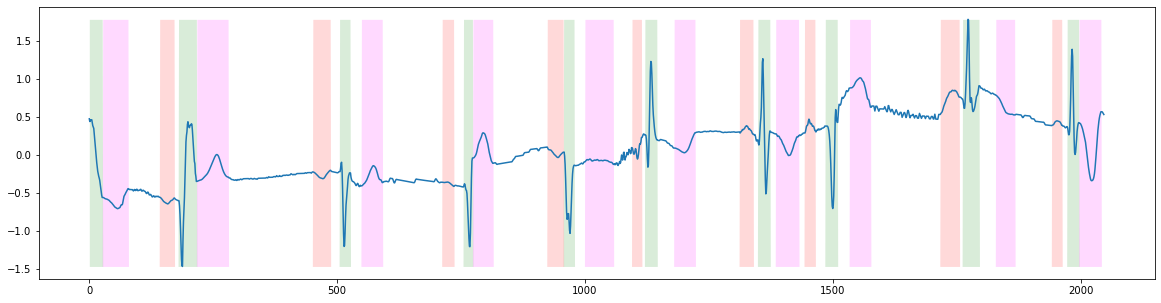

In [951]:
mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

plt.figure(figsize=(20,5))
plt.plot(signal)
plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

In [949]:
# N = 2048
# s = 3

# has_P = np.random.rand(1) > 0.1
# has_PQ = np.random.rand(1) > 0.2
# has_ST = np.random.rand(1) > 0.2
# has_BBB = np.random.rand(1) > 0.9
# counter_BBB = 0
# repetitions_BBB = np.random.randint(2,4)

# beats = []
# ids = []

# # Include first beat
# ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
# beats.append(utils.signal.on_off_correction(TPsignal[list(TPsignal)[ids[-1][1]]]))
# size = beats[0].size
# masks = np.zeros((size,),dtype='int8')
# onset = np.random.randint(0,size)
# while size-onset < N:
#     # P wave (sometimes)
#     if has_BBB:
#         if counter_BBB == 0:
#             id_BBB_P = ('Psignal',np.random.randint(0,len(Psignal)))
#         ids.append(id_BBB_P)
#         p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(p)
#         masks = np.concatenate((masks,1*np.ones((p.size,),dtype='int8')))

#         if has_PQ:
#             # PQ segment
#             ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
#             pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(pq)
#             masks = np.concatenate((masks,np.zeros((pq.size,),dtype='int8')))
#     elif (np.random.rand(1) < 0.75) and (has_P):
#         ids.append(('Psignal',np.random.randint(0,len(Psignal))))
#         p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(p)
#         masks = np.concatenate((masks,1*np.ones((p.size,),dtype='int8')))

#         if has_PQ:
#             # PQ segment
#             ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
#             pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(pq)
#             masks = np.concatenate((masks,np.zeros((pq.size,),dtype='int8')))

#     # QRS wave
#     has_QRS = np.random.rand(1)
#     if has_BBB:
#         if counter_BBB%repetitions_BBB == 0:
#             id_BBB_QRS = ('QRSsignal',np.random.randint(0,len(QRSsignal)))
#             ids.append(id_BBB_QRS)
#             qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(qrs)
#             masks = np.concatenate((masks,2*np.ones((qrs.size,),dtype='int8')))
#         else:
#             pass
#     elif (has_QRS < 0.99):
#         ids.append(('QRSsignal',np.random.randint(0,len(QRSsignal))))
#         qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(qrs)
#         masks = np.concatenate((masks,2*np.ones((qrs.size,),dtype='int8')))
    
#     # ST segment
#     if has_BBB and (counter_BBB%repetitions_BBB != 0):
#         pass
#     elif (np.random.rand(1) < 0.75) and (has_ST):
#         ids.append(('STsignal',np.random.randint(0,len(STsignal))))
#         st = trailonset(STsignal[list(STsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(st)
#         masks = np.concatenate((masks,np.zeros((st.size,),dtype='int8')))

#     # T wave
#     if has_BBB:
#         if counter_BBB%repetitions_BBB == 0:
#             ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
#             t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#             beats.append(t)
#             masks = np.concatenate((masks,3*np.ones((t.size,),dtype='int8')))
#         else:
#             pass
#     elif (has_QRS < 0.99):
#         ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
#         t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(t)
#         masks = np.concatenate((masks,3*np.ones((t.size,),dtype='int8')))

#     # TP segment
#     if has_BBB:
#         if counter_BBB == 0:
#             id_BBB_TP = ('TPsignal',np.random.randint(0,len(TPsignal)))
#         ids.append(id_BBB_TP)
#         tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(tp)
#         masks = np.concatenate((masks,np.zeros((tp.size,),dtype='int8')))
#     else:
#         ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
#         tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])[1:]
#         beats.append(tp)
#         masks = np.concatenate((masks,np.zeros((tp.size,),dtype='int8')))
    
#     # Account for total signal size
#     size = sum([beats[i].size for i in range(len(beats))])
        
#     # Update BBB counter
#     if has_BBB:
#         counter_BBB += 1

# sig = np.concatenate(beats)[onset:onset+2048]
# # sig = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250, 'high'),sig)
# signal = sig# + np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

# masks = masks[onset:onset+2048]
# masks_all = np.zeros((N,3),dtype=bool)
# masks_all[:,0] = masks == 1
# masks_all[:,1] = masks == 2
# masks_all[:,2] = masks == 3
# mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

# # f,ax = plt.subplots(nrows=1,figsize=(20,4))
# # ax = np.array(ax)
# # if len(ax.shape) == 0: ax = ax[None]
# # [ax[i].set_xlim([0,N]) for i in range(ax.size)]
# # [ax[i].fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red') for i in range(ax.size)]
# # [ax[i].fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green') for i in range(ax.size)]
# # [ax[i].fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta') for i in range(ax.size)]
# # ax[0].plot(signal)
# # # ax[1].plot(wvlts,color='orange')
# # # ax[2].plot(wvlts_signal,color='orange')

197 ms ± 74.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


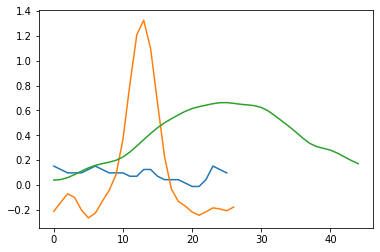

In [450]:
plt.plot(P)
plt.plot(QRS)
plt.plot(T)

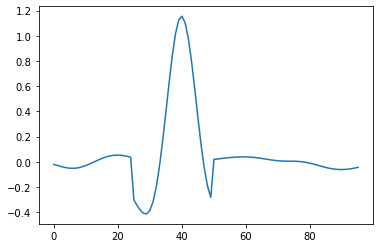

In [408]:
# plt.plot(np.concatenate((P,QRS,T)))
plt.plot(np.concatenate((Pw,QRSw,Tw)))

In [184]:
aklgljlkagj

NameError: name 'aklgljlkagj' is not defined

In [948]:
N = 2048

beats = []
ids = []

# Include first beat
ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
beats.append(utils.signal.on_off_correction(TPsignal[list(TPsignal)[ids[-1][1]]]))
# beats.append(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
size = beats[0].size
masks = np.zeros((size,))
onset = np.random.randint(0,size)
while size-onset < N:
    # P wave (sometimes)
    if np.random.rand(1) < 0.75:
        # p = utils.signal.on_off_correction(Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]])
        ids.append(('Psignal',np.random.randint(0,len(Psignal))))
        p = trailonset(Psignal[list(Psignal)[ids[-1][1]]],beats[-1][-1])
        # p = Psignal[list(Psignal)[np.random.randint(0,len(Psignal))]]
        beats.append(p)
        masks = np.concatenate((masks,1*np.ones((p.size,))))

    # PQ segment
    # pq = utils.signal.on_off_correction(PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]])
    ids.append(('PQsignal',np.random.randint(0,len(PQsignal))))
    pq = trailonset(PQsignal[list(PQsignal)[ids[-1][1]]],beats[-1][-1])
    # pq = PQsignal[list(PQsignal)[np.random.randint(0,len(PQsignal))]]
    beats.append(pq)
    masks = np.concatenate((masks,np.zeros((pq.size,))))

    # QRS wave
    # qrs = utils.signal.on_off_correction(QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]])
    ids.append(('QRSsignal',np.random.randint(0,len(QRSsignal))))
    qrs = trailonset(QRSsignal[list(QRSsignal)[ids[-1][1]]],beats[-1][-1])
    # qrs = QRSsignal[list(QRSsignal)[np.random.randint(0,len(QRSsignal))]]
    beats.append(qrs)
    masks = np.concatenate((masks,2*np.ones((qrs.size,))))

    # ST segment
    # st = utils.signal.on_off_correction(STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]])
    ids.append(('STsignal',np.random.randint(0,len(STsignal))))
    st = trailonset(STsignal[list(STsignal)[ids[-1][1]]],beats[-1][-1])
    # st = STsignal[list(STsignal)[np.random.randint(0,len(STsignal))]]
    beats.append(st)
    masks = np.concatenate((masks,np.zeros((st.size,))))

    # T wave
    # t = utils.signal.on_off_correction(Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]])
    ids.append(('Tsignal',np.random.randint(0,len(Tsignal))))
    t = trailonset(Tsignal[list(Tsignal)[ids[-1][1]]],beats[-1][-1])
    # t = Tsignal[list(Tsignal)[np.random.randint(0,len(Tsignal))]]
    beats.append(t)
    masks = np.concatenate((masks,3*np.ones((t.size,))))

    # TP segment
    # tp = utils.signal.on_off_correction(TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]])
    ids.append(('TPsignal',np.random.randint(0,len(TPsignal))))
    tp = trailonset(TPsignal[list(TPsignal)[ids[-1][1]]],beats[-1][-1])
    # tp = TPsignal[list(TPsignal)[np.random.randint(0,len(TPsignal))]]
    beats.append(tp)
    masks = np.concatenate((masks,np.zeros((tp.size,))))

    size = sum([beats[i].size for i in range(len(beats))])

w = 51
sig = np.concatenate(beats)[onset:onset+2048]
sig = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250, 'high'),sig)
signal = sig# + np.convolve(np.cumsum(norm.rvs(scale=0.15**(2*0.5),size=N)),np.hamming(w)/(w/2),mode='same')

masks = masks[onset:onset+2048]
masks_all = np.zeros((N,3),dtype=bool)
masks_all[:,0] = masks == 1
masks_all[:,1] = masks == 2
masks_all[:,2] = masks == 3
mskplt = ((np.max(signal)-np.min(signal))*masks_all)+np.min(signal)

plt.figure(figsize=(20,5))
plt.plot(signal)
plt.gca().fill_between(np.arange(N), mskplt[:,0], mskplt[:,0].min(), linewidth=0, alpha=0.15, color='red')
plt.gca().fill_between(np.arange(N), mskplt[:,1], mskplt[:,1].min(), linewidth=0, alpha=0.15, color='green')
plt.gca().fill_between(np.arange(N), mskplt[:,2], mskplt[:,2].min(), linewidth=0, alpha=0.15, color='magenta')
plt.show()

198 ms ± 39.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [314]:
ids

[('TPsignal', 513),
 ('PQsignal', 24907),
 ('QRSsignal', 15465),
 ('STsignal', 34259),
 ('Tsignal', 19058),
 ('TPsignal', 26301),
 ('Psignal', 23220),
 ('PQsignal', 31190),
 ('QRSsignal', 40671),
 ('STsignal', 40218),
 ('Tsignal', 27304),
 ('TPsignal', 16513),
 ('Psignal', 19395),
 ('PQsignal', 10618),
 ('QRSsignal', 9881),
 ('STsignal', 42863),
 ('Tsignal', 44867),
 ('TPsignal', 33973),
 ('Psignal', 32991),
 ('PQsignal', 11199),
 ('QRSsignal', 13975),
 ('STsignal', 49582),
 ('Tsignal', 29326),
 ('TPsignal', 15486),
 ('Psignal', 8934),
 ('PQsignal', 23921),
 ('QRSsignal', 35231),
 ('STsignal', 15409),
 ('Tsignal', 15071),
 ('TPsignal', 23399),
 ('Psignal', 2271),
 ('PQsignal', 35959),
 ('QRSsignal', 17824),
 ('STsignal', 10595),
 ('Tsignal', 27403),
 ('TPsignal', 7192),
 ('Psignal', 31391),
 ('PQsignal', 9509),
 ('QRSsignal', 45005),
 ('STsignal', 17205),
 ('Tsignal', 22486),
 ('TPsignal', 41708),
 ('PQsignal', 20445),
 ('QRSsignal', 52239),
 ('STsignal', 44443),
 ('Tsignal', 9834),
 (

In [ ]:
i = 46000
f = TPsignal
print(list(f)[i])
plt.plot(f[list(f)[i]])

# fiducials to delete

* QRS - 111_AVF_24
* QRS - sel820_1_156
* QRS - 95_AVR_16
* ~TP - sel306_1_211~
* ~TP - sel114_0_179~
* PT - sel803_0_109